# SPECIES PREDICTION MODEL PIPELINE (Decision tree)

NOTE: The data and EDA is based on a dummy dataset. The pipeline is created and flexible for more data.

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# for vizualizing DT
from sklearn.tree import export_graphviz 
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [2]:
df = pd.read_csv("../species_prediction_model/data/trial_data_riya.csv")
df.head()

,tag_id_long,watershed,river,site,method,local,water_temp_start,species,fork_length_mm,weight_g
0,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,NaN,co,98,NaN
1,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,NaN,co,115,NaN
2,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,NaN,rbt,106,NaN
3,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,co,113,NaN
4,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,rbt,81,NaN


In [3]:
df.isnull().sum()

tag_id_long           0
watershed             0
river                 0
site                  0
method                0
local                 0
water_temp_start      3
species               0
fork_length_mm        0
weight_g            100
dtype: int64

In [4]:
df.species.unique()

array(['co', 'rbt'], dtype=object)

This dataset only has 2 labels - co and rbt

In [5]:
for col in df.columns:
    if col not in ['tag_id_long']:
        print(col, ":", df[col].unique())

watershed : ['englishman']
river : ['shelly creek']
site : ['martindale rd']
method : ['smolt trap']
local : ['in-river']
water_temp_start : [ nan  7.   7.8  8.6 10.5 12.  10.6]
species : ['co' 'rbt']
fork_length_mm : [ 98 115 106 113  81  76 100  86  87  91  95  99 101  84  88  89  90 107
 164  93  73  74  80  82  83  85  94  97 104  96 102 105  77 119  92  78]
weight_g : [nan]


In [6]:
df= df.drop(['weight_g', 'tag_id_long'], axis = 1)
df = df.dropna()

In [7]:
df

,watershed,river,site,method,local,water_temp_start,species,fork_length_mm
3,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,co,113
4,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,rbt,81
5,englishman,shelly creek,martindale rd,smolt trap,in-river,7.8,co,76
6,englishman,shelly creek,martindale rd,smolt trap,in-river,7.8,co,100
7,englishman,shelly creek,martindale rd,smolt trap,in-river,8.6,co,86
...,...,...,...,...,...,...,...,...
95,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,co,100
96,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,co,101
97,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,rbt,78
98,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,rbt,104


## Pipeline 

### Pre-processing for the model

In [8]:
X = df.drop('species', axis = 1)
y = df['species']

In [9]:
# numeric_feats = [""]  # apply scaling
categorical_feats = ["watershed", "river", "site", "method", "local"]  # apply one-hot encoding
passthrough_feats = ["water_temp_start", "fork_length_mm"]  # do not apply any transformation
# drop_feats = [ "species" ]  
# levels = ["", ""]

In [10]:
ct = make_column_transformer (    
    #(StandardScaler(), numeric_feats),  
    ("passthrough", passthrough_feats),     
    (OneHotEncoder(), categorical_feats),  
    #("drop", drop_feats), 
    #OrdinalEncoder(categories=[levels], dtype=int)
)

In [11]:
transformed = ct.fit_transform(X)

In [12]:
column_names = (
    # numeric_feats
    passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['water_temp_start',
 'fork_length_mm',
 'watershed_englishman',
 'river_shelly creek',
 'site_martindale rd',
 'method_smolt trap',
 'local_in-river']

In [13]:
X_transformed = pd.DataFrame(transformed, columns=column_names)
X_transformed.head()

,water_temp_start,fork_length_mm,watershed_englishman,river_shelly creek,site_martindale rd,method_smolt trap,local_in-river
0,7.0,113.0,1.0,1.0,1.0,1.0,1.0
1,7.0,81.0,1.0,1.0,1.0,1.0,1.0
2,7.8,76.0,1.0,1.0,1.0,1.0,1.0
3,7.8,100.0,1.0,1.0,1.0,1.0,1.0
4,8.6,86.0,1.0,1.0,1.0,1.0,1.0


### Dummy model (Baseline)

In [14]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_transformed, y)
dummy_clf.score(X_transformed, y)

0.8247422680412371

### Decision Tree

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'max_depth': randint(1, 10), #Change to 20 when the dataset is bigger, 20 overfits currently
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(DecisionTreeClassifier(), 
                                   param_distributions=param_dist, 
                                   n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Best parameters:  {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 3}
Best Score:  0.7683333333333333


In [17]:
decision_tree = DecisionTreeClassifier(
    max_depth = random_search.best_params_["max_depth"],
    min_samples_split = random_search.best_params_["min_samples_split"],
    min_samples_leaf = random_search.best_params_["min_samples_leaf"],
    random_state = 42)

decision_tree.fit(X_train, y_train)
print("Train accuracy:", decision_tree.score(X_train, y_train))

Train accuracy: 0.8441558441558441


In [18]:
decision_tree

DecisionTreeClassifier(max_depth=8, min_samples_leaf=6, min_samples_split=3,
                       random_state=42)

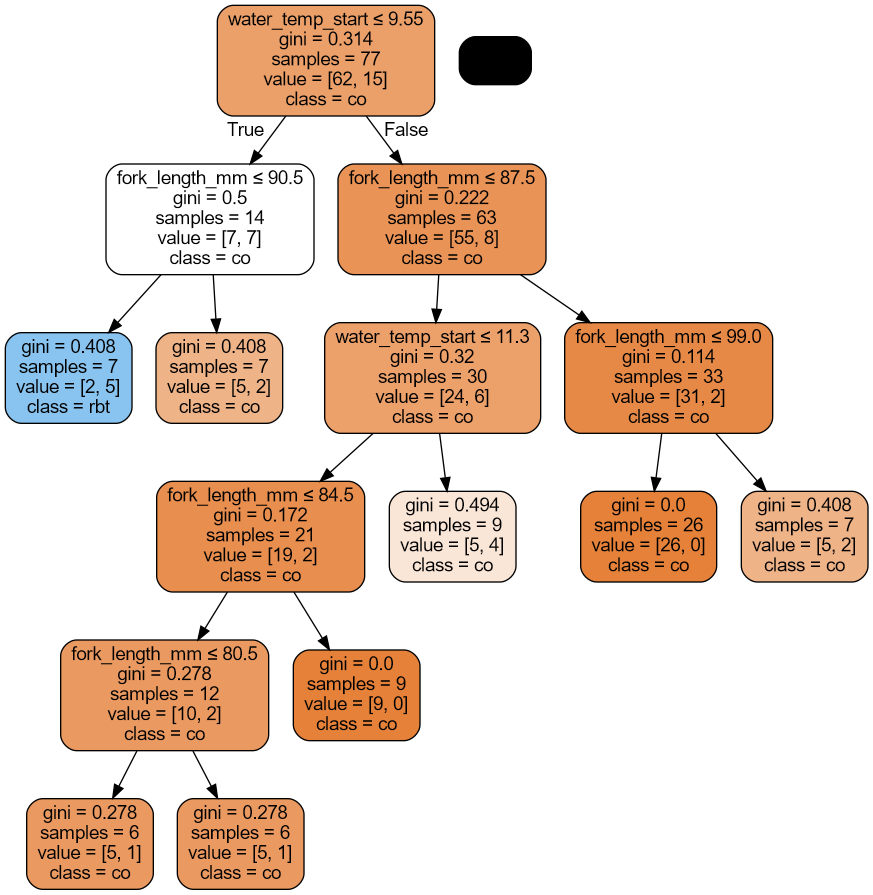

In [19]:
dot_data = StringIO()
export_graphviz(decision_tree, out_file = dot_data, filled = True, 
                rounded = True, 
                special_characters = True,
                feature_names = column_names,
                class_names = ["co", "rbt"], max_depth = 7)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("Decision_tree.png")
Image(graph.create_png())

In [20]:
print("Test score: ", decision_tree.score(X_test, y_test))

Test score:  0.9


In [21]:
y_pred = decision_tree.predict(X_test)

In [22]:
y_pred

array(['co', 'co', 'co', 'co', 'co', 'co', 'co', 'co', 'co', 'co', 'co',
       'co', 'co', 'co', 'co', 'rbt', 'co', 'rbt', 'co', 'co'],
      dtype=object)